In [1]:
import numpy as np
from matplotlib import pylab as plt
%autosave 0
%matplotlib inline

Autosave disabled


# Sentimental Analysis (Introduction)

### What is Sentimental Analysis?

Sentimental Analysis (aka "Opinion Mining") is the technique of analyzing the natural language used in subjective text-data to perceive and identify emotions. To classify a person's sentiment toward a particular subject brought up via survey responses, reviews, social media posts, email, or any other kind of textual sample, we typically generate a vocabulary based off of any relevant words used in said sample. We can then utilize that vocabulary to make classifications regarding how positive or negative the sentiment of a particular text sample is.

For example – If we do sentimental analysis in an amazon product review with over 20, 000 reviews, it can be helpful in understanding if consumers are happy about the price or different features of that product. Below is a table which shows an example of how data is extracted.

### Basic Classification Example

| Customer Feedback       | Sentiment | 
| ---                     | ---       |
|“An amazing product for a great price “ | Positive |
|“This product is not worth the price “| Negative |





### Why do we need Sentimental Analysis?

In our modern environment, companies have an enormous amount of data which consists of consumer feedback, social media tags, and many more. It is not feasible for a human to manually review that data and that’s where sentiment analysis and machine learning come into play. By running product reviews through sentiment analysis and machine learning algorithms, companies can gain a general understanding of consumer sentiment and make important design decisions about a current or future product. Sentimental Analysis can also be utilized in making investment decisions on the stock market by analyzing news sources and social media to gain an understanding of how other people feel about a particular security.

### Our approach is Machine learning-based Sentimental Analysis

Here, we train our algorithm on reviews and match them with the appropriate score. If the score is above 3.5 then it will be considered as 1 or positive and if it’s negative, then it will be below 3.5 then it will be negative or 0. Since Sentimental Analysis is considered a binary classification problem, we have decided to use Random Forest as our baseline classifier for computing accuracies. We found our average accuracy on the video game review dataset provided by Amazon to be around 0.90. In order to better compare these accuracies we decided to implement another baseline classifier, decision trees. In comparison, Decision Tree’s outputted an average accuracy of 0.83. The decision tree classifier ended up being slightly less accurate than our random forest classifier, likely due to the fact that it only utilizes one tree structure whereas random forest utilizes several decision trees during the classification process. Out of the three different classifiers that we tested, Random Forest seemed to perform the best on a consistent basis.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from IPython.display import Image

In [23]:
import pandas as pd
import gzip
import json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
# feature selection
def select_features(df, max_features):
    X = df['reviewText']
    y = df['overall']

    features = np.array(X.tolist()[:max_features])
    scores = np.array(y.tolist()[:max_features])
    
    # # shuffle the datasets in the same order
    # p = np.random.permutation(max_features)
    # features = features[p]
    # scores = scores[p]

    final_labels = []
    
    # generate labels
    for i in range(len(features)):
        if scores[i] >= 3.5:
            final_labels.append(1)
        else:
            final_labels.append(0)
    final_labels = np.array(final_labels)
    return (features, final_labels)


In [5]:
def create_bow_model(features, max_features):
    # creates an object for each item inside of a given tensor then adds them all into a list
    text_dataset = tf.data.Dataset.from_tensor_slices(features)

    max_features = max_features  # Maximum vocab size.
    max_len = 4  # Sequence length to pad the outputs to.
    embedding_dims = 2

    # # Create the vectorization layer (layer for generating the bag of words) 
    vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='count')


    # # Now that the vocab layer has been created, call `adapt` on the text-only  
    # # dataset to create the vocabulary.  
    vectorize_layer.adapt(text_dataset.batch(64))
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)

    return model

In [15]:
#generate bag of words from selected features
def generate_bow(features, max_features, model):
    input_data = features
    input_data.shape = (max_features, 1)
    features_bow = model.predict(input_data)
    return features_bow

# Random Forest and Decision Tree

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

In [6]:
def run_random_forest(features, labels):
    classifier = RandomForestClassifier(n_estimators=10)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict_proba(X_test)
    #calculate f1 scores
    y_pred=y_pred[:,1]>=0.3
    y_pred_int = y_pred.astype(np.int)
    score = f1_score(y_test, y_pred_int)

    return score

In [24]:
def run_decision_tree(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.33, random_state=42)

    nc = DecisionTreeClassifier(random_state = 2)
    nc.fit(X_train,y_train)

    y_pred = nc.predict_proba(X_test)
    #calculate f1 scores
    y_pred=y_pred[:,1]>=0.3
    y_pred_int = y_pred.astype(np.int)
    score = f1_score(y_test, y_pred_int)

    return score

# Feed Foward Neural Network 

Feedforward neural network is an artificial neural network where the node doe not form connections and it is not a cycle. It is a classification algorithm, where neuron-like units or inputs is categorized in the form of layers. Each unit is connected with the previous. The data enters at the input and flows through the network until it reaches the outputs. When it acts as a classifier to compute the accuracy, no feedback is passed among the nodes of these Layers. Below is an image 

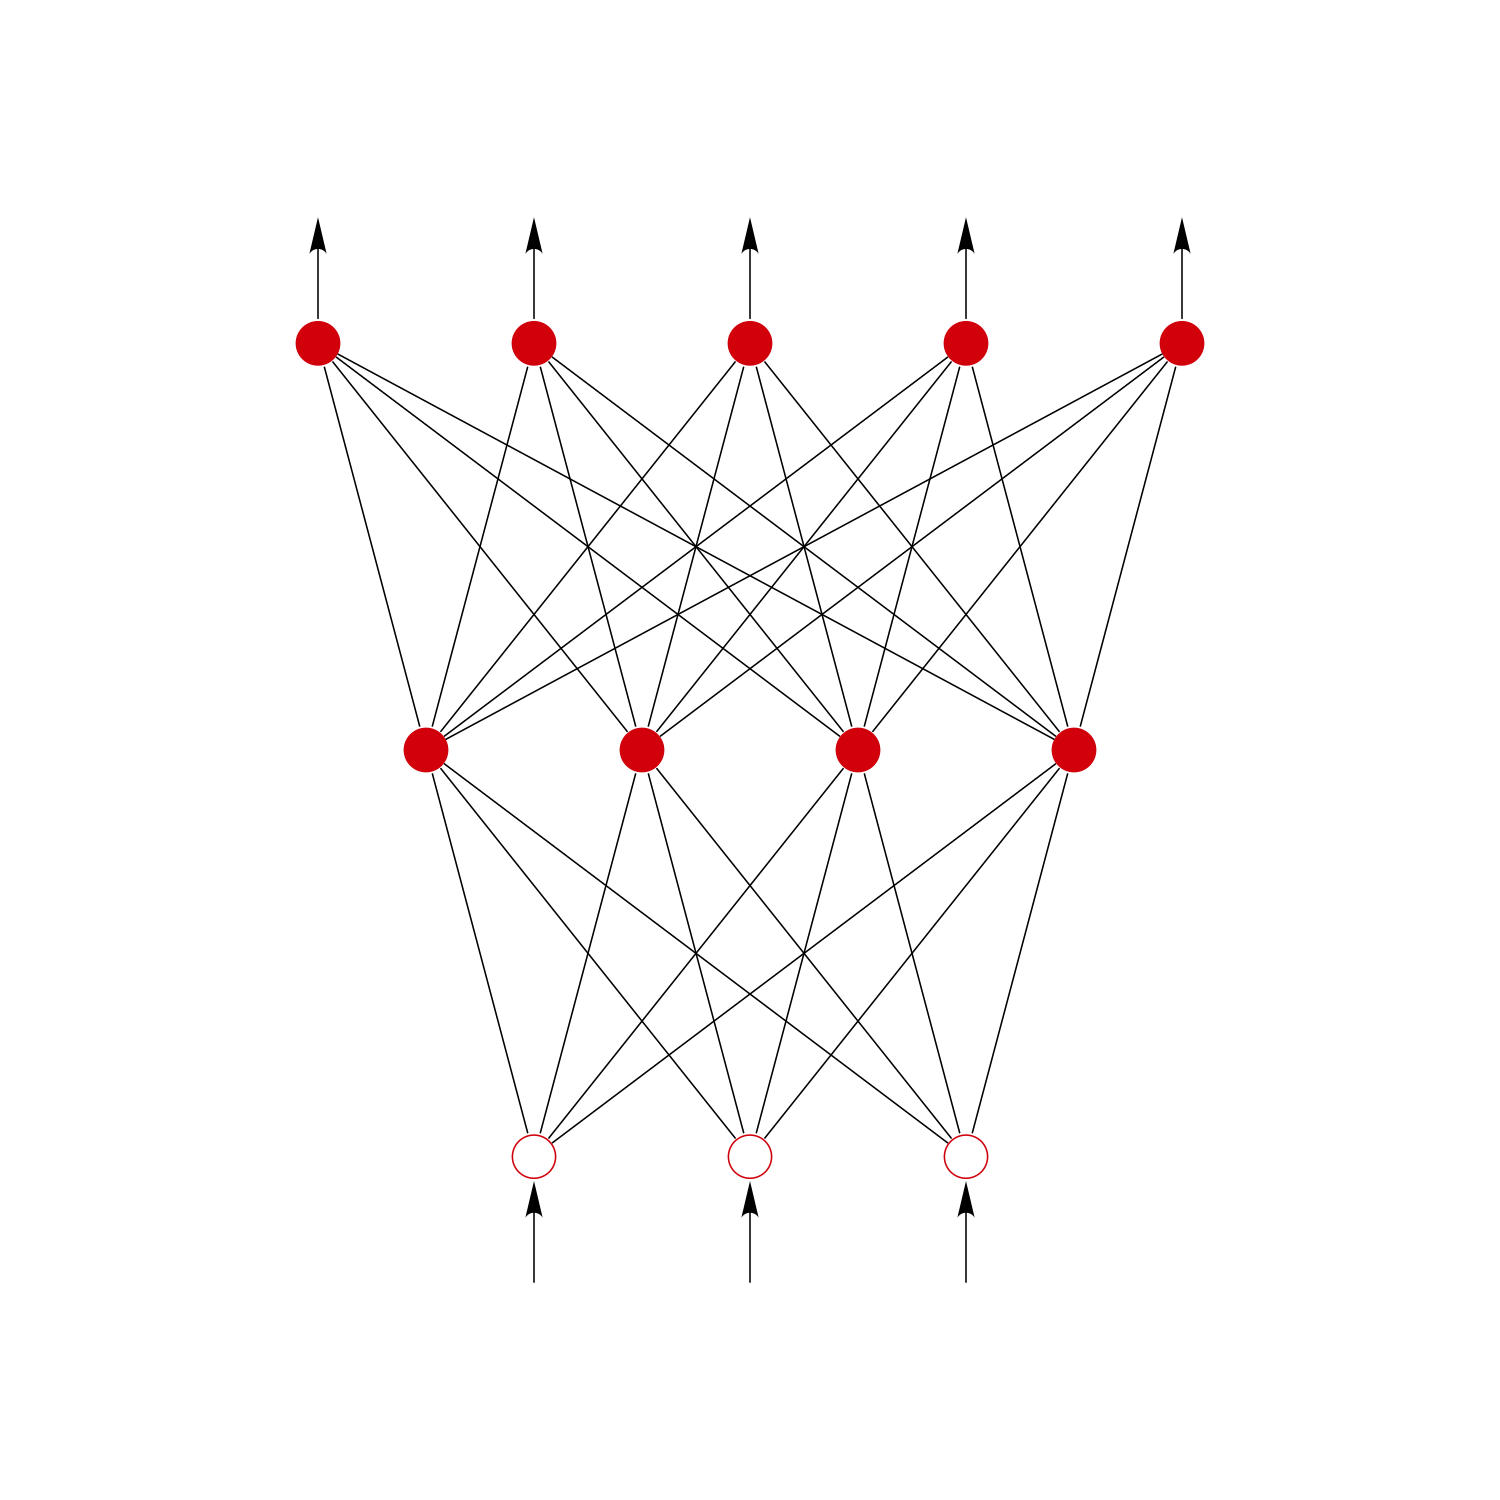

In [17]:
Image(filename = "FF.png", width = 800 , height = 200)

####  Reference 
"Feedforward neural networks 1. What is feedforward neural network ?",26th April,2004.https://www.fon.hum.uva.nl/praat/manual/Feedforward_neural_networks_1__What_is_a_feedforward_ne.html. 7th December 2020.


# Feed Foward Neural Network Implementation

In [10]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Convolution1D, GlobalMaxPooling1D

In [11]:
def build_nn_model():
    model = Sequential()
    #ReLU is widely used
    #sigmoid is used for the output layer
    #dense is basically adding layers to yout model for better input and output
    model.add(Dense(12, activation = 'relu'))
    model.add(Dense(8, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    #binary_cross used for binary classificaiton problems
    # adam = for gradient descent 
    #metric because this is a classificaiton problem 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Explanation 
A standard straightforward Feedforward neural network can implemented by just adding dense layers to a model. First we start of making a sequential constructor. A sequential constructor is a heap of linear layers. We are going to be using these Dense layers for our input and output parameteres. We have three Dense layers the first two have 12 and 8 nodes with the 'ReLU' as our activation feature. ReLU is a linear function which will output the input directly if it's positive.ReLU is easier to train and performs better. Sigmoid is for outler layer activation. 



While compiling we implemented loss as 'binary_crossentropy' , which is beneficial for binary classificaiton problems.Adam is used an optimizer to determine the gradient descent for problem.It is commonly used for natural language processing. 

In [27]:
def run_ffnn(features, labels, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.33, random_state=42)

    history = model.fit(X_train, y_train , validation_split = 0.33, epochs = 10 , batch_size = 10)
    loss, accuracy = model.evaluate(X_test, y_test)
    #the lower the loss the closer our predicitons are to the  labels 
    print("Loss = ", loss)
    print("Accuracy = ", accuracy)
    
    
    #to plot accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model for Accuracies on Training and Testing set ')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Testing'], loc = 'upper left')
    plt.show()
    
    #to plot loss 
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model for Loss ')
    plt.ylabel('Loss ')
    plt.xlabel('Epochs')
    plt.legend(['Training Loss ', 'Testing Loss'], loc = 'upper left')
    plt.show()
   
    #history object records training metrics for each epochs basically stores the variables 
    #validation split is our test size 
    #more epochs is better accuracy

In [19]:
df = getDF('Video_Games_5.json.gz')
max_features = 10000
features, labels = select_features(df, max_features)

# generate a vocabulary (bag of words) for a given set of text features 
bow_model = create_bow_model(features, max_features)
features_bow = generate_bow(features, max_features, bow_model)

In [17]:
random_forest_score = run_random_forest(features_bow, labels)
print("Accuracy on Random Forest = ", random_forest_score)

Accuracy on Random Forest =  0.917952084017066


In [25]:
decision_tree_score = run_decision_tree(features_bow, labels)
print("Accuracy on Decision Tree = " , decision_tree_score)

Accuracy on Decision Tree =  0.8807274023890177


Train on 4488 samples, validate on 2212 samples
Epoch 1/10
4488/4488 [==============================] - 1s 217us/step - loss: 0.4397 - accuracy: 0.8420 - val_loss: 0.3520 - val_accuracy: 0.8409
Epoch 2/10
4488/4488 [==============================] - 1s 188us/step - loss: 0.2362 - accuracy: 0.8993 - val_loss: 0.5352 - val_accuracy: 0.8590
Epoch 3/10
4488/4488 [==============================] - 1s 187us/step - loss: 0.1491 - accuracy: 0.9494 - val_loss: 0.4482 - val_accuracy: 0.8657
Epoch 4/10
4488/4488 [==============================] - 1s 187us/step - loss: 0.0775 - accuracy: 0.9768 - val_loss: 0.5443 - val_accuracy: 0.8644
Epoch 5/10
4488/4488 [==============================] - 1s 190us/step - loss: 0.0455 - accuracy: 0.9884 - val_loss: 0.5834 - val_accuracy: 0.8621
Epoch 6/10
4488/4488 [==============================] - 1s 190us/step - loss: 0.0309 - accuracy: 0.9929 - val_loss: 0.6769 - val_accuracy: 0.8558
Epoch 7/10
4488/4488 [==============================] - 1s 198us/step - loss

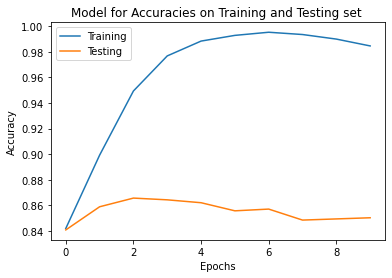

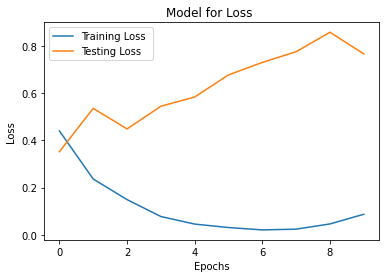

In [21]:
# ffed forward neural network model 

nn_model = build_nn_model()
run_ffnn(features_bow, labels, nn_model)


In [ ]:
df = getDF('Movies_and_TV_5.json.gz')
max_features = 10000
features, labels = select_features(df, max_features)

# generate a vocabulary (bag of words) for a given set of text features 
bow_model = create_bow_model(features, max_features)
features_bow = generate_bow(features, max_features, bow_model)

In [22]:
random_forest_score = run_random_forest(features_bow, labels)
print("Accuracy on Random Forest " , random_forest_score)

0.9031182257795564


In [26]:
decision_tree_score = run_decision_tree(features_bow, labels)
print("Accuracy on Decision Tree = " , decision_tree_score)

Accuracy on Decision Tree =  0.8807274023890177


Train on 4488 samples, validate on 2212 samples
Epoch 1/10
4488/4488 [==============================] - 1s 249us/step - loss: 0.4920 - accuracy: 0.8393 - val_loss: 0.3964 - val_accuracy: 0.8413
Epoch 2/10
4488/4488 [==============================] - 1s 240us/step - loss: 0.2968 - accuracy: 0.8821 - val_loss: 0.3803 - val_accuracy: 0.8635
Epoch 3/10
4488/4488 [==============================] - 1s 241us/step - loss: 0.1707 - accuracy: 0.9396 - val_loss: 0.4035 - val_accuracy: 0.8689
Epoch 4/10
4488/4488 [==============================] - 1s 250us/step - loss: 0.1042 - accuracy: 0.9666 - val_loss: 0.6547 - val_accuracy: 0.8626
Epoch 5/10
4488/4488 [==============================] - 1s 257us/step - loss: 0.0675 - accuracy: 0.9811 - val_loss: 0.5898 - val_accuracy: 0.8630
Epoch 6/10
4488/4488 [==============================] - 1s 240us/step - loss: 0.0478 - accuracy: 0.9869 - val_loss: 0.6762 - val_accuracy: 0.8621
Epoch 7/10
4488/4488 [==============================] - 1s 255us/step - loss

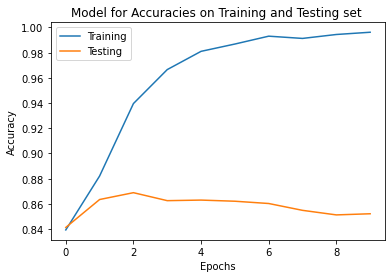

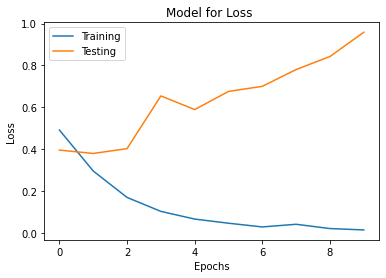

In [26]:
nn_model = build_nn_model()
run_ffnn(features_bow, labels, nn_model)

## References 

1. Malik,Usman."Python for NLP: Movie Sentiment Analysis using Deep Learning in Keras." Stack Abuse.https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/. December 7, 2020.


2. Dumbleton,Rob."Complete Guide to Sentiment analysis: Updated 2020".Insights by Thematic.https://getthematic.com/insights/sentiment-analysis/. December 7, 2020.


3. Das, Deepak."Social Media Sentiment Analysis using Machine Learning: Part-1".towards data science. Sep 6, 2019.https://towardsdatascience.com/social-media-sentiment-analysis-49b395771197. December 7, 2020.


4.  Das, Deepak."Social Media Sentiment Analysis using Machine Learning: Part-2".towards data science. Sep 22, 2019.https://towardsdatascience.com/social-media-sentiment-analysis-49b395771197. December 7, 2020.


5. Brownless,Jason."How to Develop a Deep Learning Bag-of-Words Model for Sentiment Analysis(Text Classification)". Machine Learning Mastery, October 20,2017.https://machinelearningmastery.com/deep-learning-bag-of-words-model-sentiment-analysis/. December 7, 2020.


6. "Text Classification with Sentimental Analysis    ".     https://www.samyzaf.com/ML/imdb/imdb.html. December 7,2020.


7. McCaffrey,James."Sentiment Analysis Using Keras". Visual Studio Magazine, November 15, 2018. https://visualstudiomagazine.com/articles/2018/11/01/sentiment-analysis-using-keras.aspx. December 7, 2020


8. Brownlee,Jason."Your First Deep Learning Project in Python with Keras Step-By-Step".Machine Learning Mastery, July 24,2019. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/. December 8, 2020.


9. Zhou,Victor."Keras for Beginners: Building Your First Neural Network". Victor Zhou/Blogs, June 14,2019.https://victorzhou.com/blog/keras-neural-network-tutorial/. December 8, 2020.


10. Jianmo Ni, Jiacheng Li, Julian McAuley,Empirical Methods in Natural Language Processing (EMNLP), 2019.https://nijianmo.github.io/amazon/index.html. November 21,2020.


11. Opperman, Artem."Sentiment Analysis with Deep Learning of Netflix Reviews".towards data science, Feb 24, 2019 . https://towardsdatascience.com/sentiment-analysis-with-deep-learning-62d4d0166ef6. December 7th, 2020.

12. Brownless,Jason."Display Deep Learning Model Training History in Keras".Machine Learning Mastery, October 3,2019. https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/. December 7, 2020. 


13. "Feedforward neural networks 1. What is feedforward neural network ?",26th April,2004. https://www.fon.hum.uva.nl/praat/manual/Feedforward_neural_networks_1__What_is_a_feedforward_ne.html. 7th December 2020.


14. Gupta,Tushar."Deep Learning: FeedForward Neural Network".towards data science, Jan 4, 2017. https://towardsdatascience.com/deep-learning-feedforward-neural-network-26a6705dbdc7. December 7, 2020.


15. "Sentimen Analysis: A Definite Guide". MonkeyLearn. https://monkeylearn.com/sentiment-analysis/. December 7, 2020.


